# Round 7-1: Weight–topology correlations in social networks

In this exercise, we will do some weighted network analysis using a social network data set describing private messaging in a Facebook-like web-page (Data originally from http://toreopsahl.com/datasets/).
In the network, each node corresponds to a user of the website and link weights describe the total number of messages exchanged between users. 

In the file `OClinks_w_undir.edg`, the three entries of each row describe one link:
`(node_i node_j w_ij)`, 
where the last entry `w_ij` is the weight of the link between nodes `node_i` and `node_j`.

You can use this Jupyter notebook template to get started. Below, you can find some predefined functions that will be helpful to solve the problems. In most cases, you do not need to modify these functions (but do read them through and get an idea of what each of them are doing so that you can use them in your code). Fast forward and start modifying the code after the header **"Begin of the exercise"**. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import binned_statistic

In [2]:
def create_linbins(start, end, n_bins):
    """
    Creates a set of linear bins.

    Parameters
    -----------
    start: minimum value of data, int
    end: maximum value of data, int
    n_bins: number of bins, int

    Returns
    --------
    bins: a list of linear bin edges
    """
    bins = np.linspace(start, end, n_bins)
    return bins

In [3]:
def create_logbins(start, end, n_log, n_lin=0):
    """
    Creates a combination of linear and logarithmic bins: n_lin linear bins 
    of width 1 starting from start and n_log logarithmic bins further to
    max.

    Parameters
    -----------
    start: starting point for linear bins, float
    end: maximum value of data, int
    n_log: number of logarithmic bins, int
    n_lin: number of linear bins, int

    Returns
    -------
    bins: a list of bin edges
    """
    if n_lin == 0:
        bins = np.geomspace(start, end, num=n_log+1)
    elif n_lin > 0:
        bins = np.array([start + i for i in range(n_lin)] 
                        + list(np.geomspace(start + n_lin, end, n_log+1)))
    return bins

## Data
Let us load the data from the right directory and assign the names for all the plots we will save. If you run this notebook in your machine, please specify the right directory.

In [13]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = 'some_path'

print('The data directory is %s' % course_data_dir)

network_path = os.path.join(course_data_dir, 'OClinks_w_undir.edg')

net_name = 'fb_like'
# TODO: replace with a path where to save the CCDF plot
path = './ccdfs_' + net_name + '.pdf'
# TODO: replace with a base path where to save the average link weight scatter
# A scale-related suffix will be added to this base path so the figures will not overwritten
base_path = './s_per_k_vs_k_'
# TODO: replace with a base path where to save the link neighborhood overlap plot
save_path_linkneighborhoodplot = './O_vs_w_' + net_name + '.pdf'

The data directory is /coursedata


In [18]:
#Let's read the network file
network = nx.read_weighted_edgelist(network_path)

# Begin of the exercise
Write your code here to analyze the social network dataset. 

### a. Complementary cumulative distribution

Before performing a more sophisticated analysis, let us begin with taking a look at some basic network statistics to get a rough idea of what the network is like. To this end, plot the complementary cumulative distribution function (CCDF) for node degree $k$, node strength $s$ and link weight $w$.

- Show all three distributions in one plot using loglog-scale.
- The resulting distributions have *heavy tails*, meaning that the right part of the distributions decays slower than exponentially. To see this, plot the CCDFs of the exponential distribution with the same mean as each empirical distribution, overlayed on top of the empirical ones in the same figure.
- Based visually on the empirical CCDF plots, roughly estimate the 90th percentiles of the degree, strength, and weight distributions. Explain also how they can be read off from the plots.

First, let us get the node degrees and strengths.

**Coding hints**:

- A `nx.Graph` object reports the node degrees of the network through `degree` property, that is, you can access the set of node degrees of a `nx.Graph` object `net` by `net.degree` (or equivalently `net.degree()`).

- The node strength is the sum of weights of the links incident to the node, as compared to the degree which is the number of links incident to the node. You can obtain the node strengths using the same `net.degree()` method by passing the `weight` argument as `net.degree(weight='weight')`. Read also here: https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html

- Note that the above two functions will return an iterable over the (node, degree) pairs or (node, strength) pairs. In the following, you need to convert this into a list of degrees/strengths.

- As a check, calculate the maximum degree $k_\mathrm{max}$ and maximum strength $s_\mathrm{max}$. If everything is running okay so far, you should be getting $k_\mathrm{max}$ = 255 and $s_\mathrm{max}$ = 1546.0.

In [26]:
# Get the node degrees and strengths

# degrees: DegreeView({'1': 35, '2': 5, '3': 178, ...}
degrees = network.degree
degrees = [val for idx, val in degrees]

# strengths: DegreeView({'1': 337.0, '2': 11.0, '3': 467.0, ...} 
strengths = network.degree(weight='weight')
strengths = [val for idx, val in strengths]

# Check the maxmimum degree and strength
max_degree = max(degrees)
max_strength = max(strengths)
print('Maximum degree: %d' % max_degree)
print('Maximum strength: %d' % max_strength)

Maximum degree: 255
Maximum strength: 1546


Next, let us get the link weights.

**Coding hints**:

- A `nx.Graph` object reports the edges of the network through `edges` property, that is, you can access the set of edges of a `nx.Graph` object `net` by `net.edges` (or equivalently `net.edges()`). 
- The weight of each link is stored as one of the attributes associated with the link. If you want to obtain the edges of `net` with their link attributes, use `net.edges(data=True)` or `net.edges.data()`. Both of them return the set of tuples `(i, j, data)` for each link `(i, j)` with a dictionary of attributes `data`.
- Then the information about the weight is stored as an entry in the dictionary `data`, which means you can access it by `data['weight']`.
- You can also skip generating the intermediary object `data` and directly access only the weights of the edges by using `net.edges.data('weight')`.
- Read more about using `edges` property here:
https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

In [45]:
# TODO: Get the link weights

net_data = network.edges.data('weight')
# net_data: EdgeDataView([('1', '2', 1.0), ('1', '3', 67.0), ...])
weights = [weight for i, j, weight in net_data]
# weights: [1.0, 67.0, 6.0, ...]
max_weight = max(weights)
max_weight

184.0

The following `plot_ccdf` function let you create CCDF plots. But you need to modify it first. 

**Coding hints**:

Recall that a complementary cumulative distributions is defined as $P(X \geq x)$, the proportion of data points equal to or larger than value $x$, as a function of $x$. Especially you should keep in mind the following two points.

- $P(X \geq x)$ is a non-increasing function of $x$ because if you compare two values $x_1$ and $x_2$ where $x_1 \geq x_2$, you never find more data points above $x_1$ than above $x_2$.

- When you sort the data, $P(X \geq x)$ changes its value at every data point and remains constant between two data points with different values.

- See the binning tutorial provided on the course webpage for help on computing the CCDFs (1-CDFs).

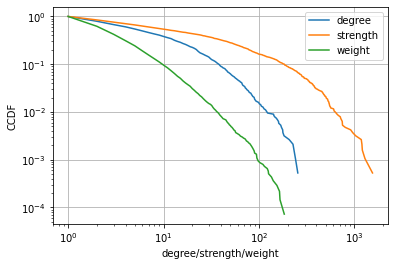

In [54]:
def plot_ccdf(datavecs, labels, styles, xlabel, ylabel):
    """
    Plots in a single figure the complementary cumulative distributions (CCDFs)
    of the given data vectors.

    Parameters
    -----------
    datavecs: data vectors to plot, a list of iterables
              e.g. [35, 5, 178, 31, 20, ...]
    labels: labels for the data vectors, list of strings
    styles: styles in which plot the distributions, list of strings
    xlabel: x label for the figure, string
    ylabel: y label for the figure, string
    """
    fig, ax = plt.subplots()
    for datavec, label, style in zip(datavecs, labels, styles):
        # Calculate CCDF of datavec and plot it
        sorted_vals = np.sort(np.unique(datavec))
        ccdf = np.zeros(len(sorted_vals))
        n = float(len(datavec))
        for i, val in enumerate(sorted_vals):
            ccdf[i] = np.sum(datavec >= val)/n
        ax.plot(sorted_vals, ccdf, "-", label=label)

    # Use loglog scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc=0)
    ax.grid()

    return fig, ax

# Let us plot the empirical CCDFs
datavecs = [degrees, strengths, weights]
styles = ['-', '--', '-.']

labels = ['degree', 'strength', 'weight']
xlabel = 'degree/strength/weight'
ylabel = 'CCDF'

fig_ccdf, ax_ccdf = plot_ccdf(datavecs, labels, styles, xlabel, ylabel)


Let's use `plot_ccdf()` to actually create the CCDF plots. Also, we plot the CCDFs of exponential distributions with matching mean with each empirical distribution.

**Hints**: 
- The CCDF of an exponential distribution with mean $\mu$ is given by $\exp(-x / \mu)$.
- Set the left x-axis limit of the plot to $1 = 10^0$ because all the variables take integer values.

(2e-05, 2)

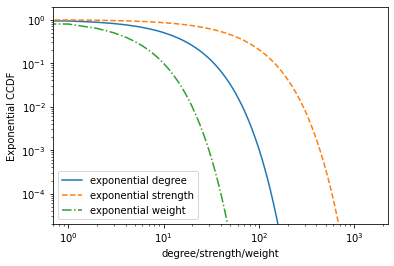

In [201]:
# Now let us plot the exponential counterparts
label_for_exp = ['exponential degree', 'exponential strength', 'exponential weight']
maximums = [max_degree, max_strength, max_weight]

# Get the mean degree, mean strength, and mean weight
import statistics
mean_degree = statistics.mean(degrees)
mean_strength = statistics.mean(strengths)
mean_weight = statistics.mean(weights)

means = [mean_degree, mean_strength, mean_weight]

fig, ax_ccdf = plt.subplots()

# Plot the exponential CCDFs
for mean, maximum, label, style in zip(means, maximums, label_for_exp, styles):
    r = list(range(int(maximum)))
    exp_l = [np.exp(-x/mean) for x in r]
    ax_ccdf.plot(exp_l, label=label, linestyle=style)

    ax_ccdf.set_xscale('log')
    ax_ccdf.set_yscale('log')

ax_ccdf.set_xlabel('degree/strength/weight')
ax_ccdf.set_ylabel('Exponential CCDF')

ax_ccdf.legend()
ax_ccdf.set_ylim(bottom=2E-5, top=2)

# fig_ccdf.savefig(path)
# print('CCDF figure saved to ' + path)

### b. Average link weight per node
Next, we will study how the average link weight per node $v =\frac{s}{k}$ behaves as a function of the node degree $k$. 

- Compute $s$, $k$, and $v = \frac{s}{k}$ for each node.

- Make a scatter plot of all the data points of $v$ as a function of $k$. Create two versions of the plots: one with linear and one with logarithmic $x$-axes.

- The large variance of the data can make the scatter plots a bit messy. To make the relationship between $v$ and $k$ more visible, create bin-averaged versions of the plots, i.e., divide nodes into bins based on their degree and calculate the average $v$ in each bin. Plot the bin-averaged versions on top of the scatter plots.

- Based on the plots, which of the two approaches (linear or logarithmic $x$-axes) suits better for presenting $v$ as a function of $k$? Why?

**Hints**:
- For the bin-averaged plots, use bins that are consistent with the scale of the horizontal axis: bins with constant width for the linear scale and logarithmic bins for the logarithmic scale. If in trouble, see the binning tutorial for help.

- An example of how the scatter and bin-averaged plots may look like is shown in Fig.1 of the assignment PDF. Obviously, the number of bins are too few in these plots. Typically, it is better to use too many than too few bins. A good choice for the number of bins in this case would be 20.

- In the bin-averaged plot, the size of the points represents the number of nodes in each bin. Check if each degree bin includes roughly the same number of nodes. Unbalanced distribution of observations may obscure the results.

In [174]:
# average link weight per node (list or numpy array)
av_weight = np.array(strengths) / np.array(degrees)
# calculate average link weight per node

n_bins = 20
n_lin = 20
min_deg = min(degrees)
max_deg = max(degrees)

# Create linear and log bins 
linbins = create_linbins(min_deg, max_deg, n_bins)
logbins = create_logbins(min_deg, max_deg, n_log=n_bins-n_lin, n_lin=n_lin)

# Take a look at the logarithmic bins
print(linbins)

[  1.          14.36842105  27.73684211  41.10526316  54.47368421
  67.84210526  81.21052632  94.57894737 107.94736842 121.31578947
 134.68421053 148.05263158 161.42105263 174.78947368 188.15789474
 201.52631579 214.89473684 228.26315789 241.63157895 255.        ]


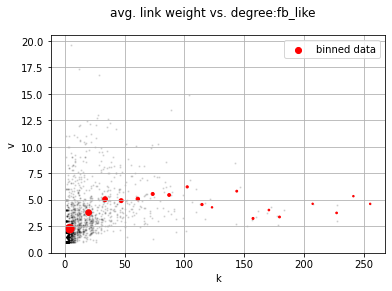

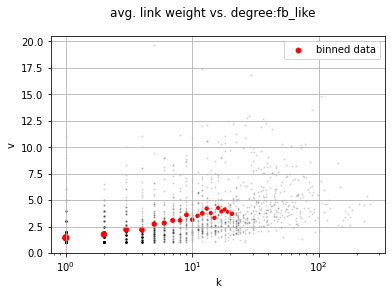

In [184]:
alpha = 0.1 # transparency of data points in the scatter

# For each of linear and logarithmic versions, the full scatter plot and 
# the bin-averaged plot can be shown in one figure.

for bins, scale in zip([linbins, logbins], ['linear', 'log']):
    fig, ax = plt.subplots()
    
    # Scatter plot all points
    ax.scatter(degrees, av_weight, marker='o', color='k', s=1.5, alpha=alpha)
    
    # bins: [  1.          14.36842105  27.73684211  41.10526316 ... ]
    # scale: "linear"

    # mean 'degree value' of each 'degree bin'
    # Use binned_statistic to get mean degree of each bin
    degree_bin_means, _, _ = binned_statistic(degrees, degrees, statistic='mean', bins=bins)

    # mean 'average link weights' in each 'degree bin'
    # Use binned_statistic to get mean of average link weights in each bin
    av_weight_bin_means, _, _ = binned_statistic(degrees, av_weight, statistic='mean', bins=bins)

    # 'number of points' in each 'degree bin'
    # Use binned_statistic to get number of data points in each bin
    counts, _, _ = binned_statistic(degrees, degrees, statistic='count', bins=bins)

    # Plotting the bin averages
    # The marker size is scaled by number of data points in the bin
    ax.scatter(degree_bin_means,
               av_weight_bin_means,
               marker='o',
               color='r',
               s=2*np.sqrt(counts),
               label='binned data')
    ax.set_xscale(scale)
    min_max = np.array([min_deg, max_deg])
    
    # Set appropriate labels
    ax.set_xlabel('k')
    ax.set_ylabel('v')
    ax.set_ylim(bottom=0.0)
    ax.grid()

    ax.legend(loc='best')
    plt.suptitle('avg. link weight vs. degree:' + net_name)
#     save_path = base_path + scale + '_' + net_name + '.pdf'
#     fig.savefig(save_path)
#     print('Average link weight scatter saved to ' + save_path)

### c. Link neighborhood overlap
Let's consider a link between nodes $i$ and $j$. For this link, *link neighborhood overlap* $O_{ij}$ is defined as the fraction of common neighbors of $i$ and $j$ out of all their neighbors: $O_{ij}=\frac{n_{ij}}{\left(k_i-1\right)+\left(k_j-1\right)-n_{ij}}.$

According to the Granovetter hypothesis, link neighborhood overlap is an increasing function of link weight in social networks. Your task is now to find out whether this is the case also for the present data set by visualizing it in an appropriate way. Use the binning strategy (linear or logarithmic) that is most suitable for this case. 

- Calculate the link neighborhood overlap for each link. To do this, you will need to modify the `get_link_overlap` function.

- Create a scatter plot showing the overlaps as a function of link weight.

- As in b), produce also a bin-averaged version of the plot on top of the scatter plot. In doing this, choose a reasonable number of bins, which, in this case, will be between 10 and 30. Specify how many bins you used.

- In the end, you should be able to spot a subtle trend in the data. Based on your plot, show if the trend is in accordance with the Granovetter hypothesis.

**Coding hints**:

- For getting common neighbors of two nodes, you can use `set` datatype and `intersection()` method.

- Naive implementation of the above definition of $O_{ij}$ will result in ZeroDivisionError for some links. Examine for what kind of links this happens. What would be the appropriate way to define $O_{ij}$ for those links?

In [131]:
def get_link_overlap(net):
    """
    Calculates link overlap: 
    O_ij = n_ij / [(k_i - 1) + (k_j - 1) - n_ij]

    Parameters
    -----------
    net: a networkx.Graph() object

    Returns
    --------
    overlaps: list of link overlaps in net
    """
    
    overlaps = []

    
    # Write a function to calculate link neighborhood overlap
    for i, j in net.edges():
        comm_neigh = nx.common_neighbors(net, i, j)
        n = len(list(comm_neigh))
        denominator = net.degree[i] - 1 + net.degree[j] - 1 - n
        # when the nodes A and B form a connected component of the graph.
        if denominator == 0:
             denominator = 1
        o = n / denominator
        overlaps.append(o)
    return overlaps

overlaps = get_link_overlap(network)

In [132]:
len(overlaps)

13838

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]


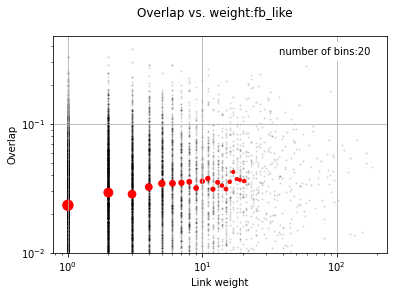

Link neighborhood overlap scatter saved as ./O_vs_w_fb_like.pdf


In [165]:

alpha = 0.1 # transparency of data points in the scatter

# creating link neighborhood overlap scatter
fig_lno, ax_lno = plt.subplots()

# TODO: Change the number of bins to the number you find reasonable between 10 and 30
n_bins = 20
n_lin = 20
min_w = np.min(weights)
max_w = np.max(weights)

linbins = create_linbins(min_w, max_w, n_bins)
logbins = create_logbins(min_w, max_w, n_log=n_bins-n_lin, n_lin=n_lin)
print(logbins)

# Try both linear and logarithmic bins, select the better one
# Specify the scale for axis that is consitent with the binning strategy

# for bins, scale in zip([linbins, logbins], ['linear', 'log']):

bins = logbins
scale = 'log'

# mean 'weight value' of each 'weight bin'
# Use binned_statistic to get mean weight of each bin
weight_bin_means, _, _ = binned_statistic(weights, weights, statistic='mean', bins=bins)

# mean 'link neighborhood overlap' of each 'weight bin'
# Use binned_statistic to get mean overlap of each bin 
overlap_bin_means, _, _ = binned_statistic(weights, overlaps, statistic='mean', bins=bins)

# 'number of points' in each 'weigth bin'
# Use binned_statistic to get number of data points
counts, _, _ = binned_statistic(weights, weights, statistic='count', bins=bins)


# plotting all points (overlap)
ax_lno.scatter(weights, overlaps, marker="o", color='k', s=1.5, alpha=alpha)
# plotting bin average, marker size scaled by number of data points in the bin
ax_lno.scatter(weight_bin_means,
           overlap_bin_means,
           s=1.5*np.sqrt(counts),
           marker='o',
           color='r')

ax_lno.set_xscale(scale)
ax_lno.set_yscale('log')
ax_lno.set_ylim(bottom=0.01)
ax_lno.grid()

#TODO: Set appropriate labels
ax_lno.set_xlabel('Link weight')
ax_lno.set_ylabel('Overlap')
ax_lno.text(0.95, 0.95, "number of bins:" + str(n_bins), 
        horizontalalignment='right', verticalalignment='top', 
        backgroundcolor='w', transform=ax_lno.transAxes)

fig_lno.suptitle('Overlap vs. weight:' + net_name)
plt.show()
print('Link neighborhood overlap scatter saved as ' + save_path_linkneighborhoodplot)